In [1]:
%%html
<style> table {margin-left: 0 !important;} </style>


=== INPUTS ===
         well radius r: 0.083
       filter radius R: 0.083
       filter length L: 10.0
           hydraulic K: 0.000864
        shape factor A: 13.113191310477738
  reference depth dref: 13.99

=== TEST DATA (Time, Depth) ===
      Time       Depth
         0       14.87
         1       14.59
         2       14.37
         3        14.2
         4       14.11
         5       14.05
         6       14.03
         7       14.01
         8          14
         9       13.99

=== OBSERVED vs MODELED (aligned by time index) ===
      Time       HwHoObs       HwHoMod  Diff(Obs-Mod)^2
         0             1             1               0
         1      0.681818      0.592444      0.00798778
         2      0.431818       0.35099      0.00653325
         3      0.238636      0.207942     0.000942166
         4      0.136364      0.123194     0.000173446
         5     0.0681818     0.0729854      2.3074e-05
         6     0.0454545     0.0432397     4.90543e-06
         

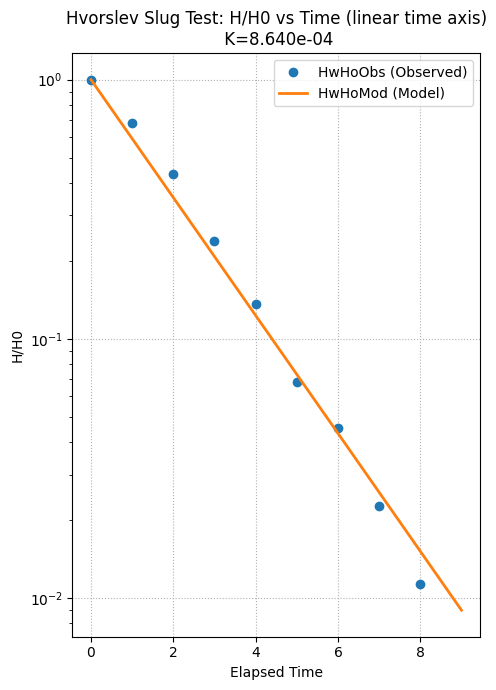

In [2]:
# Hvorslev Slug Test Analysis (enhanced I/O + log-log plot)
import math
import matplotlib.pyplot as plt

def HwHo(time, radius, conductivity, shape):
    return math.exp(time * (-conductivity * shape) / (math.pi * radius**2))

# --- Inputs ---
r = 0.083      # well radius
R = 0.083      # filter pack radius
L = 10.0       # filter pack length
K = .000864    # K guess - larger to make model plot flatter
A = 2 * math.pi * L / math.log(L / R)  # Shape factor (geometry-dependent)
dref = 13.99   # Pre-test depth to water

# --- Print inputs (1) ---
print("\n=== INPUTS ===")
print(f"{'well radius r':>22s}: {r}")
print(f"{'filter radius R':>22s}: {R}")
print(f"{'filter length L':>22s}: {L}")
print(f"{'hydraulic K':>22s}: {K}")
print(f"{'shape factor A':>22s}: {A}")
print(f"{'reference depth dref':>22s}: {dref}")

# --- Test Observations ---
etime = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.]
depth = [14.87,14.59,14.37,14.2,14.11,14.05,14.03,14.01,14,13.99]

# --- Print test data in two columns (2) ---
print("\n=== TEST DATA (Time, Depth) ===")
print(f"{'Time':>10s}  {'Depth':>10s}")
for t_i, d_i in zip(etime, depth):
    print(f"{t_i:10.6g}  {d_i:10.6g}")

# --- Computed Values ---
Hw = [d - dref for d in depth]
HwHoObs = [0.0]*len(depth)
HwHoMod = [0.0]*len(depth)
for i, (t_i, Hw_i) in enumerate(zip(etime, Hw)):
    HwHoObs[i] = Hw_i / Hw[0] if Hw[0] != 0 else float('nan')
    HwHoMod[i] = HwHo(t_i, r, K, A)

# --- Print side-by-side (3): Time, HwHoObs, HwHoMod, Diff ---
print("\n=== OBSERVED vs MODELED (aligned by time index) ===")
print(f"{'Time':>10s}  {'HwHoObs':>12s}  {'HwHoMod':>12s}  {'Diff(Obs-Mod)^2':>14s}")
for t_i, o_i, m_i in zip(etime, HwHoObs, HwHoMod):
    diff = (o_i - m_i)**2
    print(f"{t_i:10.6g}  {o_i:12.6g}  {m_i:12.6g}  {diff:14.6g}")

# --- Plot (4): linear time axis ---
plt.figure(figsize=(5,7))
plt.plot(etime, HwHoObs, marker='o', linestyle='none', label='HwHoObs (Observed)')
plt.plot(etime, HwHoMod, linewidth=2, label='HwHoMod (Model)')
plt.yscale('log') # set y-axis to display a logarithmic scale ######
plt.xlabel("Elapsed Time")
plt.ylabel("H/H0")
plt.title(f"Hvorslev Slug Test: H/H0 vs Time (linear time axis)\n K={K:.3e}")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
def W(u): # Theis well function using exponential integral
    import scipy.special as sc
    w = sc.expn(1,u)
    return(w)

def s(radius,time,storage,transmissivity,discharge): # Drawdown function using exponential integral
    import math
    u = ((radius**2)*(storage))/(4*transmissivity*time)
    s = ((discharge)/(4*math.pi*transmissivity))*W(u)
    return(s)


In [4]:
radius=7.0
time=1.0
storage=0.0051
transmissivity=299
discharge=2725

print("Drawdown is ",round(s(radius,time,storage,transmissivity,discharge),2)," meters")

Drawdown is  5.73  meters


In [5]:
def wh(u, rho): # Hantush Leaky aquifer well function
    import numpy
    """Returns Hantush's well function values

    Note: works only for scalar values of u and rho

    Parameters:
    -----------
    u : scalar  (u= r^2 * S / (4 * kD * t))
    rho : sclaar (rho =r / lambda, lambda = sqrt(kD * c))
    Returns:
    --------
    Wh(u, rho) : Hantush well function value for (u, rho)
    """
    try:
        u =float(u)
        rho =float(rho)
    except:
        print("u and rho must be scalars.")
        raise ValueError()

    LOGINF = 2
    y = numpy.logspace(numpy.log10(u), LOGINF, 1000)
    ym = 0.5 * (y[:-1]+  y[1:])
    dy = numpy.diff(y)
    wh = numpy.sum(numpy.exp(-ym - (rho / 2)**2 / ym ) * dy / ym)
    return wh

wh(0.625,5);

In [6]:
def leaky(radius,time,storage,transmissivity,discharge,leakance): # Leaky drawdown function using Hantush solution
    import math
    u = ((radius**2)*(storage))/(4*transmissivity*time)
    roB = radius/leakance
    leaky = ((discharge)/(4*math.pi*transmissivity))*wh(u,roB)
    return(leaky)

time    drawdown_obs  drawdown_mod   
5.0      0.38      0.374
28.0      1.06      1.057
41.0      1.19      1.186
60.0      1.29      1.291
75.0      1.34      1.34
244.0      1.45      1.448
493.0      1.45      1.452
669.0      1.45      1.452
958.0      1.45      1.452
1129.0      1.45      1.452
1185.0      1.45      1.452


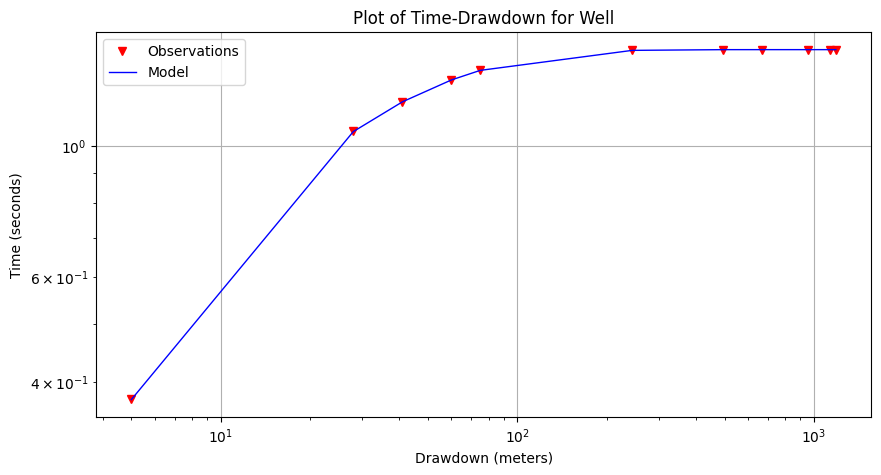

In [7]:
import matplotlib.pyplot as plt
def make2plot(listx1,listy1,listx2,listy2,strlablx,strlably,strtitle):
    mydata = plt.figure(figsize = (10,5)) # build a square drawing canvass from figure class
    plt.loglog(listx1,listy1, c='red', marker='v',linewidth=0) # basic data plot
    plt.loglog(listx2,listy2, c='blue',linewidth=1) # basic model plot
    plt.xlabel(strlablx)
    plt.ylabel(strlably)
    plt.legend(['Observations','Model'])# modify for argument insertion
    plt.grid('True')
    plt.title(strtitle)
    plt.show()
    return

import math
radius=[96] #meters
time=[5.0,28.,41.,60.,75.,244.,493.,669.,958.,1129.,1185.] #minutes
ddno=[0.375,1.057,1.186,1.291,1.34,1.448,1.452,1.452,1.452,1.452,1.452] #feet
ddnm=[0 for i in range(len(time))] # list of zeros to hold results
# simulation constants
Khorizontal = 0.73 #m/d
bthick = 5.2 #m
transmissivity = Khorizontal*bthick
storage = 0.0035
discharge = 28 #m^3/d
bprime = 1.1 #meters
Kvert = 5.5e-5 #m/day
# computed constants
B = math.sqrt((transmissivity*bprime)/Kvert)
# compute the drawdowns
for i in range(len(time)):
    ddnm[i]=leaky(radius[0],time[i],storage,transmissivity,discharge,B)
# print results
print("time    drawdown_obs  drawdown_mod   ")
for i in range(len(time)):
    print(round(time[i],1),"    ",round(ddno[i],2),"    ",round(ddnm[i],3))

make2plot(time,ddno,time,ddnm,"Drawdown (meters)","Time (seconds)","Plot of Time-Drawdown for Well")
